# LSTM

## 라이브러리

In [49]:
import pandas as pd
import numpy as np
import re               # Regular Expression
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용

# 토크나이징/인코딩 관련 라이브러리
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.utils import np_utils

# 모델링 관련 라이브러리
from tensorflow.keras.models import load_model

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 



데이터 불러오기

In [50]:
X_train = np.array(pd.read_csv('./data/mecab/X_train.csv'))
X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))

y_train_1 = np.array(pd.read_csv('./data/mecab/y_train.csv')['0'])
y_test_1 =  np.array(pd.read_csv('./data/mecab/y_test.csv')['0'])

y_train_2 = np.array(pd.read_csv('./data/mecab/y_train.csv')['1'])
y_test_2 =  np.array(pd.read_csv('./data/mecab/y_test.csv')['1'])

y_train_3 = np.array(pd.read_csv('./data/mecab/y_train.csv')['2'])
y_test_3 =  np.array(pd.read_csv('./data/mecab/y_test.csv')['2'])

print(len(X_train), len(X_test), len(y_train_1), len(y_test_1))

740000 185002 740000 185002


In [51]:
# 한국표준산업분류 딕셔너리 불러오기

with open('./data/dictionary/digit_1_dict.pickle', 'rb') as handle:
    digit_1_dict = pickle.load(handle)

with open('./data/dictionary/digit_2_dict.pickle', 'rb') as handle:
    digit_2_dict = pickle.load(handle)

with open('./data/dictionary/digit_3_dict.pickle', 'rb') as handle:
    digit_3_dict = pickle.load(handle)

In [52]:
# 레이블 인코딩

le = preprocessing.LabelEncoder()

y_train_1 = le.fit_transform(y_train_1)
y_test_1 = le.fit_transform(y_test_1)

y_train_1 = np_utils.to_categorical(y_train_1)
y_test_1 = np_utils.to_categorical(y_test_1)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 32753
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(19, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_1, epochs=10, callbacks=[es, mc], batch_size=128, validation_split=0.2)

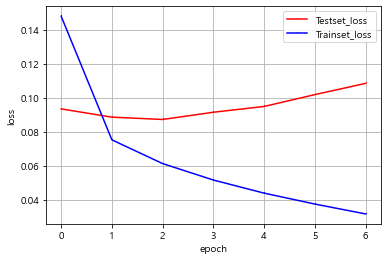

In [ ]:
y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loaded_model = load_model('./data/model/digit_1_best.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_1)[1]))

5782/5782 [==============================] - 24s 4ms/step - loss: 0.0866 - acc: 0.9757

 테스트 정확도: 0.9757


## 대분류 예측기

In [59]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [61]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit_1_best.h5')
max_len = 10
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv', encoding='CP949')


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le.inverse_transform([label.argmax()])[0])
  print(digit_1_dict[le.inverse_transform([label.argmax()])[0]])

In [ ]:
y_test_predicted = pd.DataFrame(loaded_model.predict(X_test))

In [62]:
sentiment_predict("음식점에서|접객시설을 갖추고|참치회(일본식)")

음식점에서접객시설을 갖추고참치회일본식
['음식점', '에서', '접객', '시설', '을', '갖추', '고', '참치', '회일', '본식']
['음식점', '에서', '접객', '시설', '을', '갖추', '고', '참치', '회일', '본식']
[[24, 1, 11, 8, 2, 9, 6, 981, 6963, 9705]]
[[  24    1   11    8    2    9    6  981 6963 9705]]
[[5.7924325e-07 1.1308610e-08 1.9358824e-05 4.5463850e-09 1.9337454e-09
  4.3329024e-07 4.5647630e-05 8.8319587e-07 9.9990976e-01 7.3331243e-09
  2.6308946e-09 1.5008824e-07 2.7252206e-06 6.1356773e-06 7.7741253e-09
  1.8083243e-06 3.2122675e-06 4.4442691e-06 4.8269562e-06]]
I
숙박 및 음식점업(55~56)
